1.) What was the change in price of the stock over time?

2.) What was the daily return of the stock on average?

3.) What was the moving average of the various stocks?

4.) What was the correlation between different stocks'?

5.) How much value do we put at risk by investing in a particular stock?

6.) How can we attempt to predict future stock behavior? (Predicting the closing price stock price of APPLE inc using LSTM)

# LSTM - Stock Market Analysis

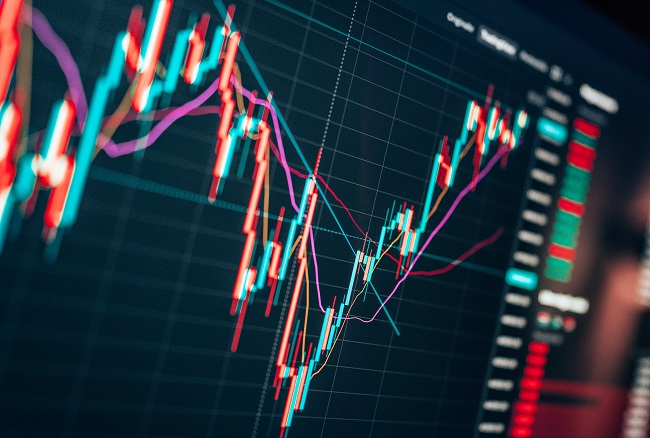

In [ ]:
# 증권데이터 가져오기 위해서 설치
!pip install -q yfinance

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from pandas_datareader import data as pdr
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

##### 1. 분석에 사용할 기업을 리스트로 저장하세요.

In [ ]:
# 분석에 사용할 주식 티커
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN', 'TSLA', 'NVDA']

##### 2. 학습에 사용할 데이터의 기간을 설정하세요. (예: 최근 1년)

In [ ]:
# 데이터 기간 설정 (예: 최근 1년)
end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)

In [ ]:
# 데이터 예시
yf.download("AAPL", start=start, end=end).head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2024-03-18,172.903580,176.874834,172.704523,174.744891,75604200
2024-03-19,175.252502,175.780010,172.216833,173.520674,55215200
2024-03-20,177.830307,177.830307,174.267130,174.894174,53423100
2024-03-21,170.564621,176.655870,170.037113,176.217935,106181300
2024-03-22,171.470337,172.236722,169.260769,170.952776,71106600


##### 3. 각 기업의 'Adj Close' 데이터를 가져와 하나의 DataFrame으로 결합하세요.

In [ ]:
# 각 기업의 'Adj Close' 데이터를 가져와 하나의 DataFrame으로 결합
closing_df = pd.DataFrame()
for ticker in tech_list:
    df = yf.download(ticker, start=start, end=end, auto_adjust=False)[['Adj Close']]
    df.rename(columns={'Adj Close': ticker}, inplace=True)
    # 날짜를 인덱스로 사용하며 inner join (모든 종목이 거래된 날만 남음)
    if closing_df.empty:
        closing_df = df
    else:
        closing_df = closing_df.join(df, how='inner')


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
# 결합된 DataFrame 확인
print("Combined closing prices:")
print(closing_df.head(3))

Combined closing prices:
Price             AAPL        GOOG        MSFT        AMZN        TSLA  \
Ticker            AAPL        GOOG        MSFT        AMZN        TSLA   
Date                                                                     
2024-03-18  172.903580  147.780045  414.158020  174.479996  173.800003   
2024-03-19  175.252502  147.222687  418.217072  175.899994  171.320007   
2024-03-20  177.830307  148.974380  422.008148  178.149994  175.660004   

Price            NVDA  
Ticker           NVDA  
Date                   
2024-03-18  88.425941  
2024-03-19  89.368645  
2024-03-20  90.342316  


##### 4. 결합된 DataFrame을 확인해보세요.

In [ ]:
# DataFrame 확인
closing_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 251 entries, 2024-03-18 to 2025-03-18
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   (AAPL, AAPL)  251 non-null    float64
 1   (GOOG, GOOG)  251 non-null    float64
 2   (MSFT, MSFT)  251 non-null    float64
 3   (AMZN, AMZN)  251 non-null    float64
 4   (TSLA, TSLA)  251 non-null    float64
 5   (NVDA, NVDA)  251 non-null    float64
dtypes: float64(6)
memory usage: 13.7 KB


In [ ]:
closing_df.describe()

Price,AAPL,GOOG,MSFT,AMZN,TSLA,NVDA
Ticker,AAPL,GOOG,MSFT,AMZN,TSLA,NVDA
count,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000
mean,217.068025,173.615772,420.535250,195.954861,260.586813,120.049797
std,24.275369,13.439391,16.599151,19.398122,85.943444,18.655035
min,164.224564,147.222687,378.769989,161.020004,142.050003,76.174973
25%,207.906242,164.153259,411.261093,182.084999,184.019997,108.411682
50%,224.256287,172.258102,418.553864,187.970001,232.100006,123.509560
75%,232.753716,182.923157,429.338013,208.825005,334.700012,135.167572
max,258.735504,207.473633,464.854340,242.059998,479.859985,149.416245


In [ ]:
closing_df.corr()

,Price,AAPL,GOOG,MSFT,AMZN,TSLA,NVDA
,Ticker,AAPL,GOOG,MSFT,AMZN,TSLA,NVDA
Price,Ticker,,,,,,
AAPL,AAPL,1.000000,0.575011,0.247572,0.611991,0.768379,0.852000
GOOG,GOOG,0.575011,1.000000,0.444796,0.800054,0.744898,0.583466
MSFT,MSFT,0.247572,0.444796,1.000000,0.254844,0.249777,0.374643
AMZN,AMZN,0.611991,0.800054,0.254844,1.000000,0.903646,0.584326
TSLA,TSLA,0.768379,0.744898,0.249777,0.903646,1.000000,0.693784
NVDA,NVDA,0.852000,0.583466,0.374643,0.584326,0.693784,1.000000


##### 5. 데이터 학습에 방해가 되는 결측치를 제거해주세요.

In [ ]:
# 결측치 제거
closing_df.dropna(inplace=True)

#### LSTM 입력 데이터 생성 (multivariate)

##### 1. 학습에 원활할 수 있도록 각 열 별로 0~1 범위로 스케일링을 해주겠습니다.

**스케일링**

입력과 출력 데이터를 별도로 MinMaxScaler를 사용해 0~1 범위로 스케일링합니다.

In [ ]:
# 스케일링: 각 열별로 0~1 범위로 변환
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(closing_df.values)  # shape: (n_samples, 6)

##### 2. 시퀀스의 길이(lookback)를 60으로 설정해주세요.

**시퀀스 데이터 생성**

과거 60일 간의 모든 피처(각 기업의 OHLCV)를 입력으로 사용하고, 그 다음 날의 각 기업 'Close' 가격을 타겟으로 설정합니다.

In [ ]:
# 시퀀스 길이(lookback)
sequence_length = 60

##### 3. 입력 데이터와 타겟 데이터로 분할을 하고 위에서 설정한 시퀀스의 길이를 바탕으로 다음날의 종목 가격을 예측하겠습니다.

In [ ]:
# 입력(x)와 타겟(y) 생성: 과거 60일 데이터를 바탕으로 다음 날 6개 종목 가격 예측
x_data = []
y_data = []
for i in range(sequence_length, len(scaled_data)):
    x_data.append(scaled_data[i-sequence_length:i, :])
    y_data.append(scaled_data[i, :])

In [ ]:
x_data, y_data = np.array(x_data), np.array(y_data)
print("x_data shape:", x_data.shape)  # (samples, 60, 6)
print("y_data shape:", y_data.shape)  # (samples, 6)

x_data shape: (191, 60, 6)
y_data shape: (191, 6)


##### 4. 학습 데이터와 테스트 데이터의 비율은 95%로 설정하겠습니다.

In [ ]:
# 학습/테스트 데이터 분할 (예: 95% train)
train_size = int(0.95 * len(x_data))
x_train = x_data[:train_size]
y_train = y_data[:train_size]
x_test = x_data[train_size:]
y_test = y_data[train_size:]

#### LSTM 모델 구성 및 학습

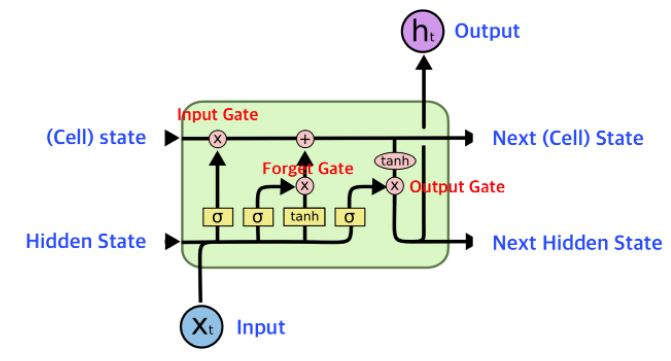

**모델 구성 및 학습**

두 개의 LSTM 레이어와 Dense 레이어로 구성된 모델을 학습합니다.

##### 1. 학습에 필요한 LSTM 모델을 구현한 뒤, 학습까지 진행해주십시오.



In [ ]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(sequence_length, len(tech_list))))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25, activation='relu'))
model.add(Dense(len(tech_list)))

model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
history = model.fit(x_train, y_train, batch_size=16, epochs=5, validation_split=0.1)

Epoch 1/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 196ms/step - loss: 0.2740 - val_loss: 0.0530
Epoch 2/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - loss: 0.0531 - val_loss: 0.0427
Epoch 3/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - loss: 0.0385 - val_loss: 0.0446
Epoch 4/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step - loss: 0.0308 - val_loss: 0.0600
Epoch 5/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 252ms/step - loss: 0.0234 - val_loss: 0.0611


#### 예측 및 결과 확인

**평가 및 시각화**

테스트 데이터에 대해 예측을 수행한 후, 각 기업별 RMSE를 계산합니다.

서브플롯(2행 3열)으로 각 기업의 실제 'Close' 가격과 예측값을 시각화합니다.

##### 1. 예측 결과를 통해서 모델을 평가해보세요.

In [ ]:
predictions = model.predict(x_test)
predictions_inverse = scaler.inverse_transform(predictions)
y_test_inverse = scaler.inverse_transform(y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


##### 2. 각 종목별로 RMSE를 계산해보세요.

In [ ]:
# RMSE 계산 (각 종목별)
rmse = np.sqrt(np.mean((predictions_inverse - y_test_inverse) ** 2, axis=0))
print("RMSE for each company:")
for ticker, error in zip(tech_list, rmse):
    print(f"{ticker}: {error:.2f}")

RMSE for each company:
AAPL: 16.35
GOOG: 14.59
MSFT: 48.30
AMZN: 9.49
TSLA: 116.59
NVDA: 15.60


##### 3. 예측한 데이터와 실제 데이터를 가지고 시각화를 진행해보겠습니다.

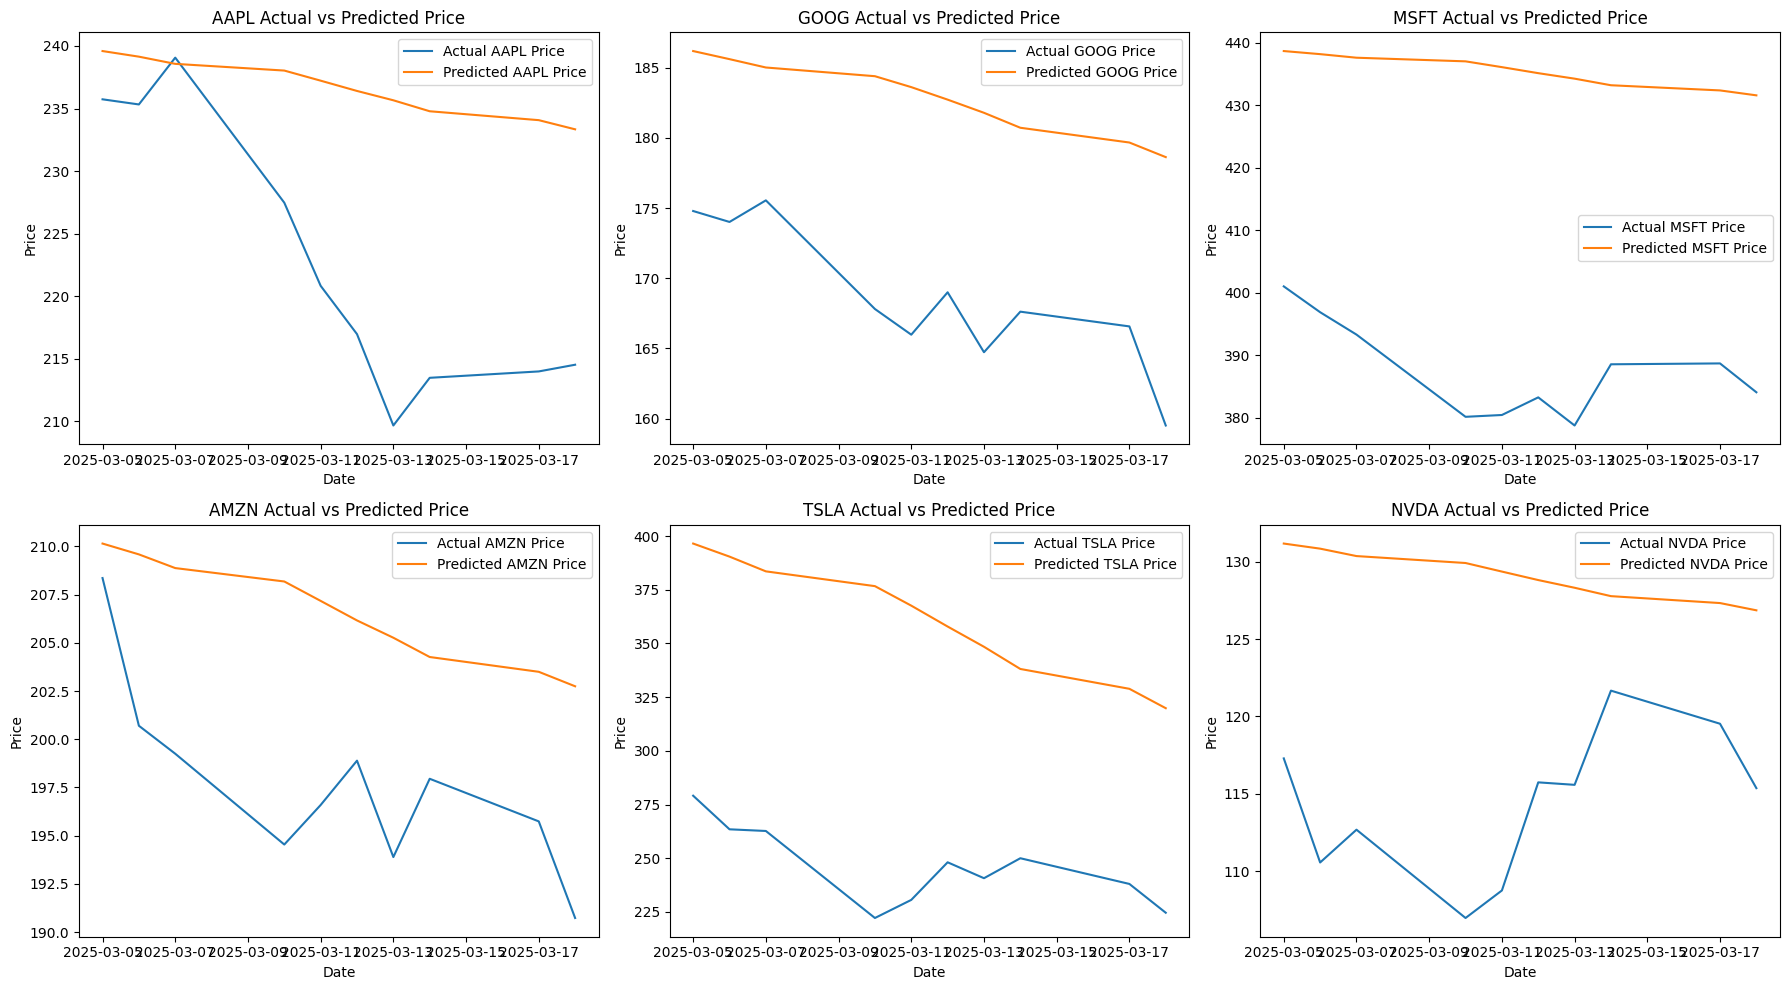

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
axs = axs.flatten()

for i, ticker in enumerate(tech_list):
    ax = axs[i]
    ax.plot(closing_df.index[-len(y_test):], y_test_inverse[:, i], label=f"Actual {ticker} Price")
    ax.plot(closing_df.index[-len(y_test):], predictions_inverse[:, i], label=f"Predicted {ticker} Price")
    ax.set_title(f"{ticker} Actual vs Predicted Price")
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    ax.legend()

plt.tight_layout()
plt.show()


다변량 입력(여러 피처)을 사용하여 LSTM 모델을 구성하면, 단일 'Close' 가격만 사용했을 때보다 보다 다양한 정보(예: 시가, 고가, 저가, 거래량 등)를 반영할 수 있으므로 예측 성능 향상에 도움이 될 수 있습니다.


수업은 이론과 실습이 혼합되어 있으며, 각 파트마다 코드의 역할과 LSTM 모델의 기본 개념, 데이터 전처리, 모델 구성 및 평가 방법에 대해 설명합니다.

---

# [수업 대본: 다변량 LSTM을 활용한 주가 예측]

## 1. 수업 개요 (10분)
- **목표:**  
  - LSTM의 기본 개념 이해  
  - 다변량 시계열 데이터를 활용하여 주가 예측 모델 구성  
  - OHLCV(시가, 고가, 저가, 종가, 거래량) 데이터를 활용한 데이터 전처리, 모델 학습 및 평가 방법 습득

- **수업 진행 순서:**  
  1. 시계열 데이터와 주식 데이터 개요  
  2. 데이터 수집 및 전처리 (OHLCV 데이터 결합 및 스케일링)  
  3. LSTM 모델의 기본 개념과 아키텍처  
  4. 모델 구성, 학습 및 평가  
  5. 예측 결과 시각화 및 오차 개선 방안 토론

---

## 2. 주식 데이터와 시계열 예측 개념 (15분)
- **주식 데이터란?**  
  - 주식 거래에서 자주 사용하는 데이터: Open, High, Low, Close, Volume  
  - 'Close' 가격이 조정된 종가로 나타나는 경우가 많지만, 오늘은 모든 피처(Open, High, Low, Close, Volume)를 함께 사용하여 다변량 입력을 구성합니다.

- **시계열 데이터의 특성**  
  - 시간 순서에 따라 정렬된 데이터  
  - 계절성, 추세, 노이즈 등 다양한 패턴 존재  
  - 미래 값을 예측하는 데 RNN과 LSTM 같은 순환 신경망이 효과적임

- **LSTM의 기본 개념**  
  - LSTM(Long Short-Term Memory)은 RNN의 일종으로, 장기 의존성 문제를 해결하도록 고안됨  
  - 셀 상태(cell state)와 게이트(입력, 삭제, 출력 게이트)를 통해 정보를 선택적으로 기억하거나 잊음  
  - 시계열 데이터, 언어 모델 등에서 널리 사용됨

---

## 3. 데이터 수집 및 전처리 (25분)
- **데이터 수집**  
  - yfinance 라이브러리를 사용해 티커 목록(예: AAPL, GOOG, MSFT, AMZN, TSLA, NVDA)의 데이터를 다운로드  
  - 각 티커별로 Open, High, Low, Close, Volume 데이터를 가져오고, 컬럼명에 티커 접두어를 추가하여 혼동을 방지함  
  - 여러 티커의 데이터를 날짜 기준으로 결합(inner join)하여, 모든 종목의 데이터가 존재하는 날짜만 선택함

- **코드 설명:**  
  - 각 티커별 데이터 프레임 생성 및 컬럼 이름 변경  
  - `pd.concat(df_list, axis=1, join='inner')`를 통해 하나의 DataFrame으로 결합  
  - 결측치 제거: `df_all.dropna(inplace=True)`

- **스케일링**  
  - 모델 학습 전에 입력과 출력 데이터를 각각 0~1 사이로 변환하기 위해 MinMaxScaler 사용  
  - 입력: 전체 피처(각 기업의 OHLCV, 즉 기업 수 × 5)  
  - 출력: 예측 대상은 각 기업의 'Close' 가격

- **실습 팁:**  
  - 데이터의 분포를 확인하고, 시각화하여 이상치나 결측치가 있는지 점검  
  - 스케일링 전후 데이터의 범위를 확인해 보는 것이 좋음

---

## 4. 시퀀스 데이터 생성 (15분)
- **시퀀스 생성 이유**  
  - LSTM 모델은 일정 기간(lookback window)의 연속된 데이터를 입력으로 받음  
  - 여기서는 과거 60일의 데이터를 사용해 다음 날의 각 기업 'Close' 가격을 예측하도록 구성

- **코드 설명:**  
  - for 루프를 사용하여 인덱스 `i`가 60부터 시작하도록, `x_data`에는 지난 60일 간의 전체 피처, `y_data`에는 해당 시점의 출력 대상(각 기업 'Close')을 저장  
  - `x_data`의 shape: (samples, 60, 총 피처 수), `y_data`의 shape: (samples, 기업 수)

- **학생 질문 예상:**  
  - “왜 60일인가요?” → 60일은 예시로 선택한 값이며, 실험적으로 최적의 기간을 찾을 수 있음  
  - “출력은 왜 한 시점의 값인가요?” → 모델이 하루 뒤의 가격을 예측하도록 구성했기 때문

---

## 5. LSTM 모델 구성 및 학습 (30분)
- **모델 아키텍처 개요**  
  - 두 개의 LSTM 레이어를 사용:  
    - 첫 번째 LSTM 레이어(128 유닛, return_sequences=True) → 시퀀스 전체를 다음 LSTM에 전달  
    - 두 번째 LSTM 레이어(64 유닛, return_sequences=False) → 최종 시퀀스 정보 추출
  - Dense 레이어를 통해 중간 특징 추출 (25 노드, ReLU 활성화)
  - 최종 출력 Dense 레이어: 예측 출력 차원은 기업 수(6)

- **모델 컴파일**  
  - 옵티마이저: Adam  
  - 손실 함수: mean_squared_error (MSE)

- **학습 과정**  
  - 배치 크기, 에포크 수, 검증 분할 등을 지정하여 모델 학습  
  - 학습 중 검증 손실과 학습 손실을 모니터링하여 과적합 여부 확인

- **코드 설명:**  
  - 각 레이어의 역할과 파라미터에 대해 자세히 설명  
  - “왜 LSTM을 두 개 사용했는지”, “Dense 레이어의 역할은 무엇인지” 등 질문 유도  
  - 실습: 에포크 수나 배치 크기를 변경해 보고 결과에 미치는 영향을 실시간으로 확인

---

## 6. 예측 및 평가 (15분)
- **예측 수행**  
  - 학습된 모델을 사용해 테스트 데이터에 대해 예측 진행  
  - 예측 결과는 스케일된 값이므로, scaler_y를 이용해 원래 단위로 역변환

- **평가 지표**  
  - RMSE(Root Mean Squared Error)를 사용해 각 기업별 예측 오차 계산  
  - RMSE가 낮을수록 모델 성능이 우수함

- **코드 설명:**  
  - `np.sqrt(np.mean((predictions_inverse - y_test_inverse) ** 2, axis=0))`를 통해 RMSE 계산  
  - 각 티커별 RMSE 출력 및 해석

- **토론:**  
  - “예측 오차가 크다면 어떤 개선 방법을 고려할 수 있을까요?”  
    - 데이터 양/피처 추가, 모델 아키텍처 변경, 하이퍼파라미터 튜닝 등

---

## 7. 예측 결과 시각화 (20분)
- **시각화 목적**  
  - 모델의 예측 결과와 실제 주가를 비교하여 모델의 성능을 직관적으로 파악  
  - 각 기업별 예측 결과를 서브플롯으로 한 화면에 나타내어 비교

- **코드 설명:**  
  - subplot(2행 3열)으로 각 기업의 실제 'Close' 가격과 예측값을 그래프로 표시  
  - x축: 날짜, y축: 가격  
  - legend, title, xlabel, ylabel 등 그래프 설정 방법 설명

- **실습 팁:**  
  - 그래프 스타일, 색상, 레이블 등 다양한 옵션을 실습하며 시각적 개선 방법을 고민

---

## 8. Q&A 및 개선 방법 토론 (10분)
- **학생 질문 받기:**  
  - “왜 auto_adjust 옵션이 중요한가요?”  
    - 데이터의 조정 여부에 따라 'Adj Close'와 'Close' 컬럼의 차이가 있음  
  - “모델의 성능을 높이기 위한 추가 피처는 무엇이 있을까요?”  
    - 기술적 지표, 거래량 변화율, 경제 지표 등  
  - “왜 LSTM을 선택했나요?”  
    - 시계열 데이터의 장기 의존성을 고려할 때 효과적임

- **개선 방법 제안:**  
  - 추가 피처(예: 기술적 지표) 도입  
  - 모델 하이퍼파라미터 튜닝 (에포크, 배치 크기, 레이어 수 등)  
  - 다른 모델(예: GRU, Transformer)과의 비교 실험

---

## 9. 마무리 (5분)
- **요약:**  
  - 다변량 입력을 통해 여러 피처를 학습하는 LSTM 모델 구성 방법 습득  
  - 데이터 전처리, 시퀀스 데이터 생성, 모델 구성 및 평가 과정 복습  
  - 예측 결과 시각화를 통해 모델의 성능을 직관적으로 확인

- **과제:**  
  - 각자 관심 있는 주식 데이터를 선택하여 동일한 방법으로 모델을 구성해 보기  
  - 에포크 수, lookback 기간 등 하이퍼파라미터를 변경하며 성능 비교해 보기

- **추가 자료:**  
  - LSTM 기본 개념, 시계열 예측 관련 논문 및 블로그 포스트 추천

---
